In [1]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import io

In [2]:
# Upload the file
uploaded = files.upload()
file_name = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

Saving cleaned_housing_data.csv to cleaned_housing_data.csv


In [3]:
#Shape and first 5 rows
print(f"Shape: {df.shape}")
print(df.head())

# Data types
print("\n=== Data Types ===")
print(df.dtypes)

# Missing values
print("\n=== Missing Values ===")
print(df.isnull().sum())

# Descriptive statistics
print("\n=== Descriptive Statistics ===")
print(df.describe(include='all'))

Shape: (541, 15)
      price  area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0  13300000  7420         4          2        3         1          0   
1  12250000  8960         4          4        4         1          0   
2  12250000  9960         3          2        2         1          0   
3  12215000  7500         4          2        2         1          0   
4  11410000  7420         4          1        2         1          1   

   basement  hotwaterheating  airconditioning  parking  prefarea  \
0         0                0                1        2         1   
1         0                0                1        3         0   
2         1                0                0        2         1   
3         1                0                1        3         1   
4         1                0                1        2         0   

   furnishingstatus  price_per_sqft  bed_bath_ratio  
0                 2     1792.452830             2.0  
1                 2     1367.1875

In [4]:
df['area_per_room'] = df['area'] / df['bedrooms']
df['total_rooms'] = df['bedrooms'] + df['bathrooms']

In [5]:
df['furnishingstatus'] = df['furnishingstatus'].map({0:'unfurnished', 1:'semi-furnished', 2:'furnished'})

In [7]:
X = df.drop(['price', 'price_per_sqft'], axis=1)
y = df['price']
X = pd.get_dummies(X, columns=['furnishingstatus'], drop_first=True)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
scaler = StandardScaler()
num_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'bed_bath_ratio', 'area_per_room', 'total_rooms']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [10]:
model = RandomForestRegressor(n_estimators=200,
                            max_depth=10,
                            random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

In [11]:
y_pred = model.predict(X_test)


In [12]:
print("\nModel Performance:")
print(f"Mean Absolute Error: ${mean_absolute_error(y_test, y_pred):,.2f}")
print(f"R-squared Score: {r2_score(y_test, y_pred):.4f}")


Model Performance:
Mean Absolute Error: $898,230.67
R-squared Score: 0.6448


In [13]:
df['luxury_score'] = df['airconditioning'] + df['prefarea'] + df['parking']
df['bathroom_ratio'] = df['bathrooms'] / df['bedrooms']

In [15]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15]
}
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [100, 200, 300]})

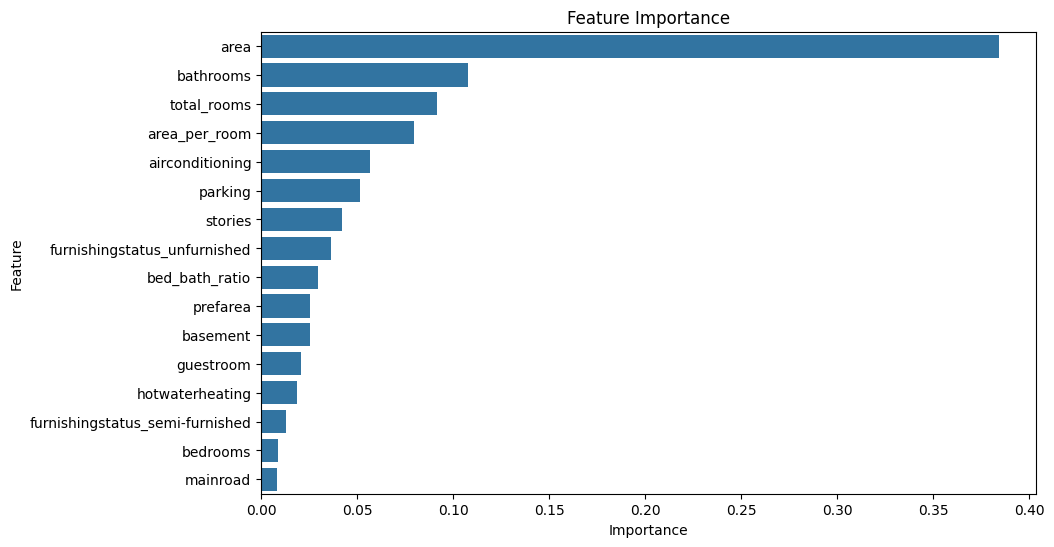

In [17]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': grid_search.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

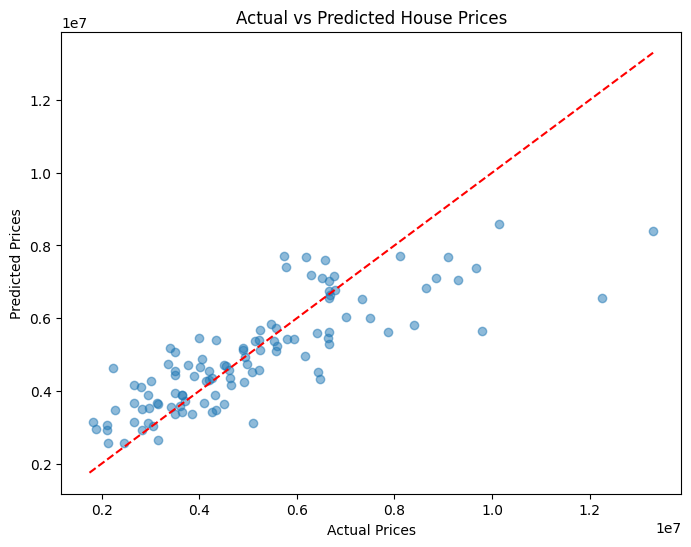

In [18]:
# Actual vs Predicted Plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted House Prices')
plt.show()

In [ ]:
# Save Model and Preprocessors
import joblib
joblib.dump(model, 'house_price_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Download the files
files.download('house_price_model.pkl')
files.download('scaler.pkl')